# Analysis


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import MultiPoint, Point, Polygon,shape
import random
import warnings
import statsmodels.api as sm
from patsy import dmatrices
import geopy.distance
import geopandas as gpd
import pyperclip
import sklearn.metrics as sk

In [9]:
labels={'acqua': 'Water fountains',
        'biblio':   'Public libraries',
        'ciclabili':'Bike lanes',
        'consu':    'Family counselling',
        'cult':	    'Cultural POI',
        'distr':    'Stores and Groceries',
        'edicole':  'News-stands',
        'farmacie':	'Pharmacies',
        'metro':    'Metro stations',
        'parchi':	'Public parks',
        'posta':    'Postal offices',
        'serd': 	'Addiction counselling',
        'sinf':	    'Kindergarten',
        'sita':	    'Italian schools',
        'sport':	'Sport facilities',
        'sprim':	'Elementary schools',
        'ss2':      'High schools',
        'ssec':     'Middle schools',
        'treni':    'Train stations',
        'uni':      'University buildings',
        'df_name':  'Service',
        'all': 'All services'
        }

col_list = ['acqua', 'biblio', 'ciclabili','consu','cult', 'edicole', 'farmacie', 'metro', 'parchi', 'posta', 'serd', 'sinf', 'sita', 'sport', 'sprim', 'ss2', 'ssec', 'treni', 'uni', 'wifi', 'distr','all']

## Data Cleaning and preprocessing

In [10]:
calc_df_fixed=pd.read_csv('../outputs/calc_fixed_df.csv', low_memory=False)
mm_df=pd.read_csv('../outputs/mm_dataset.csv')
#removing all non geolocated services
calc_df_fixed = calc_df_fixed.drop(calc_df_fixed[calc_df_fixed['long'].isna()].index)
calc_df_fixed

,name,long,lat,df_name,cat1,cat2,cat1_name,cat2_name,10001708,10001709,...,51039101,51039401,51039402,51039403,51039404,51039405,51039406,51039407,51039408,51039410
0,FORZE ARMATE,9.107364,45.456290,acqua,NaN,NaN,NaN,NaN,7540.1,7540.1,...,4609.7,8467.6,8467.6,8467.6,8467.6,8467.6,8467.6,8467.6,8467.6,8467.6
1,LORENTEGGIO,9.125151,45.458188,acqua,NaN,NaN,NaN,NaN,6445.5,6445.5,...,3735.9,7593.8,7593.8,7593.8,7593.8,7593.8,7593.8,7593.8,7593.8,7593.8
2,BANDE NERE,9.136149,45.461792,acqua,NaN,NaN,NaN,NaN,5797.8,5797.8,...,3165.9,7023.8,7023.8,7023.8,7023.8,7023.8,7023.8,7023.8,7023.8,7023.8
3,GIAMBELLINO,9.153322,45.452348,acqua,NaN,NaN,NaN,NaN,4673.6,4673.6,...,3846.8,7651.5,7651.5,7651.5,7651.5,7651.5,7651.5,7651.5,7651.5,7651.5
4,GRATOSOGLIO - Q.RE MISSAGLIA - Q.RE TERRAZZE,9.171006,45.408128,acqua,NaN,NaN,NaN,NaN,5655.9,5655.9,...,8094.3,10803.3,10803.3,10803.3,10803.3,10803.3,10803.3,10803.3,10803.3,10803.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13264,licenza madre ce palizzi,9.138032,45.507393,distr,alimentare|non alimentare,NaN,settore_merceologico,NaN,7640.8,7640.8,...,1647.7,3452.3,3452.3,3452.3,3452.3,3452.3,3452.3,3452.3,3452.3,3452.3
13265,NaN,9.097103,45.450728,distr,alimentare|non alimentare,NaN,settore_merceologico,NaN,8231.1,8231.1,...,5498.1,9356.0,9356.0,9356.0,9356.0,9356.0,9356.0,9356.0,9356.0,9356.0
13266,la rinascente s.p.a.,9.151735,45.489729,distr,alimentare|non alimentare,NaN,settore_merceologico,NaN,5841.5,5841.5,...,1041.9,4315.4,4315.4,4315.4,4315.4,4315.4,4315.4,4315.4,4315.4,4315.4
13269,NaN,9.158760,45.479925,distr,Non Alimentare|Alimentare|,NaN,settore_merceologico,NaN,5143.7,5143.7,...,1948.4,5203.1,5203.1,5203.1,5203.1,5203.1,5203.1,5203.1,5203.1,5203.1


Cleaning all housing units outside of comune di milano

<Axes: >

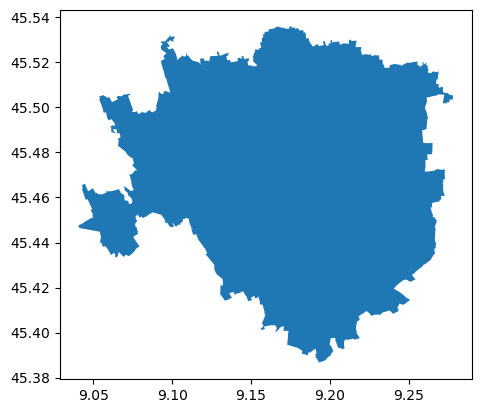

In [11]:
shape=gpd.read_file(r"../datasets/milan_shape/A090101_ComuneMilano.shp")
shape=shape.to_crs(epsg=4326)
shape.plot()

In [12]:
mm_gdf = gpd.GeoDataFrame(
    mm_df, geometry=gpd.points_from_xy(mm_df.lon, mm_df.lat), crs="EPSG:4326"
)
points_within = gpd.sjoin(mm_gdf, shape, predicate='within')
ed_in=points_within['CODICE EDIFICIO'].to_list()

## Summary statistics

In [13]:
desc_mm=calc_df_fixed.groupby('df_name').describe()
desc_mm=desc_mm.drop(['long', 'lat'], axis=1)
desc_mm=desc_mm.T
desc_mm.head()

df_name               acqua       biblio    ciclabili        consu  \
10001708 count    52.000000    26.000000  3722.000000    21.000000   
         mean   4837.286538  4852.173077  4710.625631  3401.933333   
         std    2227.730313  2356.413434  2021.426698  1740.142727   
         min     300.000000   732.400000   167.700000  1149.100000   
         25%    3003.850000  2909.925000  3254.175000  2033.500000   

df_name                cult        distr      edicole     farmacie  \
10001708 count    75.000000   847.000000   562.000000   414.000000   
         mean   3293.048000  3922.098229  4272.305160  4305.478261   
         std     978.047843  1758.667532  1940.521378  2024.596546   
         min    1743.900000   578.900000   342.800000   233.000000   
         25%    2801.900000  2658.950000  2807.500000  2879.775000   

df_name               metro       parchi  ...         serd         sinf  \
10001708 count   110.000000  1065.000000  ...    15.000000   263.000000   
         mean   5610.150909  4802.970047  ...  4445.560000  4764.759696   
         std    3056.697970  2108.603931  ...  1921.965073  2176.150858   
         min    1174.400000   172.600000  ...  2578.400000   201.800000   
         25%    3591.875000  3716.500000  ...  3333.200000  3084.600000   

df_name                sita        sport        sprim          ss2  \
10001708 count   114.000000  1041.000000  1718.000000   174.000000   
         mean   4274.764035  5144.240346  4792.983818  4073.697701   
         std    2024.712556  2223.316616  2151.748558  1787.300165   
         min     455.300000   168.200000   302.400000   819.000000   
         25%    2918.900000  3472.400000  3121.600000  2981.025000   

df_name                ssec        treni          uni         wifi  
10001708 count  1128.000000    24.000000   711.000000   596.000000  
         mean   4544.281294  4543.304167  3615.077637  4699.220638  
         std    2058.149003  2247.137897  1642.314869  2046.524959  
         min     302.400000   879.500000   906.800000   204.500000  
         25%    2922.825000  3174.725000  2450.500000  3049.850000  

[5 rows x 21 columns]

In [14]:
min_services=calc_df_fixed.groupby('df_name').min()
min_services=min_services.drop(['long', 'lat', 'cat1_name', 'cat2_name'], axis=1)
desc_services=pd.DataFrame()
desc_services['min']=min_services.min(axis=1)
desc_services['id_min']=min_services.idxmin(axis=1)
max_services=calc_df_fixed.groupby('df_name').min()
max_services=max_services.drop(['long', 'lat', 'cat1_name', 'cat2_name'], axis=1)
desc_services['max']=max_services.max(axis=1)
desc_services['id_max']=max_services.idxmax(axis=1)
avg_services=calc_df_fixed.groupby('df_name').mean()
desc_services['avg']=avg_services.mean(axis=1)
sd_services=calc_df_fixed.groupby('df_name').std()
desc_services['sd']=avg_services.std(axis=1)
desc_services

C:\Users\iodio\AppData\Local\Temp\ipykernel_13248\2763110821.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  min_services=calc_df_fixed.groupby('df_name').min()
C:\Users\iodio\AppData\Local\Temp\ipykernel_13248\2763110821.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  max_services=calc_df_fixed.groupby('df_name').min()
C:\Users\iodio\AppData\Local\Temp\ipykernel_13248\2763110821.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_services=calc_df_fixed.groupb

,min,id_min,max,id_max,avg,sd
df_name,,,,,,
acqua,42.9,51038202,11575.4,30002301,5935.911171,2235.464750
biblio,25.2,41021101,12616.0,30002301,5632.558962,2315.507204
ciclabili,7.7,51023704,10128.4,30002301,5721.943063,2305.164419
consu,18.8,30001601,13996.4,30002301,5313.805646,2344.355278
cult,52.8,20000804,13431.4,30002301,4809.684327,2404.639622
distr,31.7,51010801,11501.2,30002301,5297.161646,2333.650571
edicole,6.0,10001902,11254.5,30002301,5487.967377,2305.300919
farmacie,0.0,30003501,10912.3,30002301,5510.082684,2299.712785
metro,33.8,10003802,10959.2,51014401,6635.089023,2229.341552


In [15]:
max_20=calc_df_fixed.groupby('df_name').min()
max_20=max_20.drop(['long', 'lat', 'cat1_name', 'cat2_name'], axis=1)
max_20=max_20.T
max_20

C:\Users\iodio\AppData\Local\Temp\ipykernel_13248\4154215261.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  max_20=calc_df_fixed.groupby('df_name').min()


df_name,acqua,biblio,ciclabili,consu,cult,distr,edicole,farmacie,metro,parchi,...,serd,sinf,sita,sport,sprim,ss2,ssec,treni,uni,wifi
10001708,300.0,732.4,167.7,1149.1,1743.9,578.9,342.8,233.0,1174.4,172.6,...,2578.4,201.8,455.3,168.2,302.4,819.0,302.4,879.5,906.8,204.5
10001709,300.0,732.4,167.7,1149.1,1743.9,578.9,342.8,233.0,1174.4,172.6,...,2578.4,201.8,455.3,168.2,302.4,819.0,302.4,879.5,906.8,204.5
10001710,300.0,732.4,167.7,1149.1,1743.9,578.9,342.8,233.0,1174.4,172.6,...,2578.4,201.8,455.3,168.2,302.4,819.0,302.4,879.5,906.8,204.5
10001711,300.0,732.4,167.7,1149.1,1743.9,578.9,342.8,233.0,1174.4,172.6,...,2578.4,201.8,455.3,168.2,302.4,819.0,302.4,879.5,906.8,204.5
10001712,300.0,732.4,167.7,1149.1,1743.9,578.9,342.8,233.0,1174.4,172.6,...,2578.4,201.8,455.3,168.2,302.4,819.0,302.4,879.5,906.8,204.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51039405,832.8,952.8,372.5,644.2,4377.2,837.7,514.8,756.2,532.6,1489.9,...,2969.7,350.9,564.3,745.3,425.6,1077.7,717.5,557.6,2607.6,573.5
51039406,832.8,952.8,372.5,644.2,4377.2,837.7,514.8,756.2,532.6,1489.9,...,2969.7,350.9,564.3,745.3,425.6,1077.7,717.5,557.6,2607.6,573.5
51039407,832.8,952.8,372.5,644.2,4377.2,837.7,514.8,756.2,532.6,1489.9,...,2969.7,350.9,564.3,745.3,425.6,1077.7,717.5,557.6,2607.6,573.5
51039408,832.8,952.8,372.5,644.2,4377.2,837.7,514.8,756.2,532.6,1489.9,...,2969.7,350.9,564.3,745.3,425.6,1077.7,717.5,557.6,2607.6,573.5


(array([724., 125.,  20.,  15.,   1.,   4.,   3.,  26.,  11.,   1.]),
 array([   17.5 ,  1305.05,  2592.6 ,  3880.15,  5167.7 ,  6455.25,
         7742.8 ,  9030.35, 10317.9 , 11605.45, 12893.  ]),
 <BarContainer object of 10 artists>)

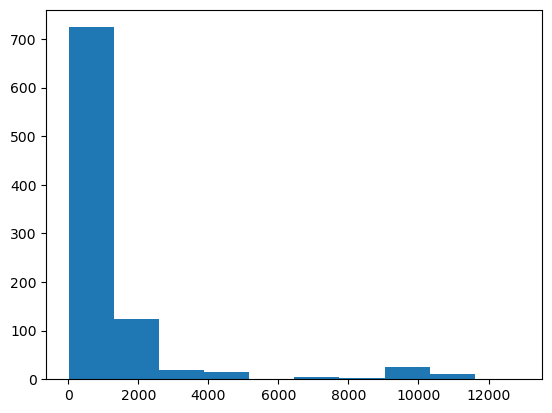

In [16]:
plt.hist(max_20['ss2'])

# Index calculator

We construct the index as illustrated in the paper, note that in this notebook we just prove the concept, the full calculation takes place in another file (index.py)

In [17]:
def penality_function(x, dhat):
    if x <= dhat:
        return 1
    if x > dhat:
        return 1/(x-dhat+1)

def con_index(dist_list, dhat, n_max, alpha, beta):
    if  alpha + beta != 1:
        raise Exception("Alpha and Beta should sum to one")
    d_min = min(dist_list)
    close_list=[d for d in dist_list if d <=dhat]
    n = len(close_list)
    CI = alpha*penality_function(d_min, dhat)+beta*(n/n_max)
    return CI

con_index([9,6,6,6,6], 5, 3, 0.5, 0.5)

0.25

In [18]:
def best_in_class(df_name, dhat, df=calc_df_fixed):
    e_list=list(df.columns)
    e_list=[item for item in e_list if item not in ['name', 'long', 'lat','df_name', 'cat1', 'cat2', 'cat1_name', 'cat2_name']]
    nmax_dict=dict.fromkeys(e_list)
    if df_name=='all':
        pass
    else:
        df=df[df.df_name==df_name]
    for elem in e_list:
        dist_list=list(df[str(elem)])
        close_list=[d for d in dist_list if d <=dhat]
        nmax_dict[elem]=len(close_list)
    return max(nmax_dict.values())

best_in_class('biblio', 60*15)

3

In [19]:
min(calc_df_fixed['10002602'].to_list())

30.2

In [20]:
mm_columns_list=['CODICE EDIFICIO', 'full_address', 'lat', 'lon']
index_df=mm_df[mm_columns_list]
index_df

,CODICE EDIFICIO,full_address,lat,lon
0,10001708,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053
1,10001709,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053
2,10001710,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053
3,10001711,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053
4,10001712,VIA DEL TURCHINO 22 MILANO,45.451893,9.228053
...,...,...,...,...
975,51039405,VIA SENIGALLIA 60/G MILANO,45.532143,9.168970
976,51039406,VIA SENIGALLIA 60 MILANO,45.532143,9.168970
977,51039407,VIA SENIGALLIA 60 MILANO,45.532143,9.168970
978,51039408,VIA SENIGALLIA 60 MILANO,45.532143,9.168970


In [21]:
columns_list=list(calc_df_fixed.df_name.unique())+['all']
[best_in_class(name, 60*15)  for name in columns_list] #checking if function works for all dataframes

[3,
 3,
 342,
 5,
 47,
 58,
 31,
 10,
 173,
 8,
 5,
 14,
 14,
 58,
 80,
 24,
 86,
 4,
 190,
 53,
 223,
 896]

In [22]:
def fun_run(codice_edificio, dhat, alpha, beta, out_df, df=calc_df_fixed):
    columns_list=list(df.df_name.unique())+['all']
    #out_dict
    out_list=[]
    col_out_list=[]
    for column in columns_list:
        if column=='all':
            df_subset=df

        else:
            df_subset=df[df.df_name==column]
        dist_list=df_subset[str(codice_edificio)].to_list()
        if dist_list==[]:
            out=np.nan
            warnings.warn("Empty list")
        else:
            n_max=best_in_class(column, dhat)
            try:
                out=con_index(dist_list=dist_list, dhat=dhat, n_max=n_max, alpha=alpha, beta=beta)
            except:
                out=np.nan
                warnings.warn("Index not calculated because of some issue")
        col_out_list.append(column)
        out_list.append(out)
    if col_out_list == ['acqua', 'biblio', 'ciclabili','consu','cult', 'edicole', 'farmacie', 'metro', 'parchi', 'posta', 'serd', 'sinf', 'sita', 'sport', 'sprim', 'ss2', 'ssec', 'treni', 'uni', 'wifi', 'distr','all']:
        return out_list
    else:
        raise Exception("Not all columns are outputs of fun run")


fun_run(10003003, dhat=60*15, alpha=0.5, beta=0.5, out_df=index_df)

[1.0,
 0.8333333333333333,
 0.5570175438596491,
 0.8,
 0.5106382978723404,
 0.6120689655172413,
 0.7580645161290323,
 0.6,
 0.5982658959537572,
 0.6875,
 0.6,
 0.8928571428571428,
 0.5357142857142857,
 0.7586206896551724,
 0.85625,
 0.5833333333333334,
 0.686046511627907,
 0.0027716186252771603,
 0.5263157894736842,
 0.5943396226415094,
 0.547085201793722,
 0.6635044642857143]

## Index Analysis

We now perform the analysis of the index created

In [23]:
index_df=pd.read_csv('../outputs/index_df.csv')
print('Buildings that were not geocoded',len(index_df[index_df['lon'].isna()]))
index_df=index_df.drop(index_df[index_df['lon'].isna()].index) #dropping mm buildings that were not geocoded
index_df= index_df[index_df['CODICE EDIFICIO'].isin(ed_in)] #dropping buildings outside comune di milano
index_df.loc[:, index_df.columns != 'list'].to_stata('../stata/index_df.dta') #exporting to dta file
index_df

Buildings that were not geocoded 49


C:\Users\iodio\AppData\Local\Temp\ipykernel_13248\2635143699.py:5: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    CODICE EDIFICIO   ->   CODICE_EDIFICIO

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  index_df.loc[:, index_df.columns != 'list'].to_stata('../stata/index_df.dta') #exporting to dta file


,CODICE EDIFICIO,full_address,lat,lon,list,acqua,biblio,ciclabili,consu,cult,...,sita,sport,sprim,ss2,ssec,treni,uni,wifi,distr,all
0,10001708,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053,"[0.6666666666666666, 0.6666666666666666, 0.627...",0.666667,0.666667,0.627193,0.001999,0.000592,...,0.571429,0.594828,0.63125,0.541667,0.593023,0.625,0.064103,0.566038,0.515695,0.614397
1,10001709,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053,"[0.6666666666666666, 0.6666666666666666, 0.627...",0.666667,0.666667,0.627193,0.001999,0.000592,...,0.571429,0.594828,0.63125,0.541667,0.593023,0.625,0.064103,0.566038,0.515695,0.614397
2,10001710,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053,"[0.6666666666666666, 0.6666666666666666, 0.627...",0.666667,0.666667,0.627193,0.001999,0.000592,...,0.571429,0.594828,0.63125,0.541667,0.593023,0.625,0.064103,0.566038,0.515695,0.614397
3,10001711,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053,"[0.6666666666666666, 0.6666666666666666, 0.627...",0.666667,0.666667,0.627193,0.001999,0.000592,...,0.571429,0.594828,0.63125,0.541667,0.593023,0.625,0.064103,0.566038,0.515695,0.614397
4,10001712,VIA DEL TURCHINO 22 MILANO,45.451893,9.228053,"[0.6666666666666666, 0.6666666666666666, 0.627...",0.666667,0.666667,0.627193,0.001999,0.000592,...,0.571429,0.594828,0.63125,0.541667,0.593023,0.625,0.064103,0.566038,0.515695,0.614397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,51039405,VIA SENIGALLIA 60/G MILANO,45.532143,9.168970,"[0.6666666666666666, 0.009293680297397777, 0.5...",0.666667,0.009294,0.527778,0.600000,0.000144,...,0.571429,0.594828,0.70000,0.002798,0.639535,0.625,0.000293,0.528302,0.502242,0.561384
976,51039406,VIA SENIGALLIA 60 MILANO,45.532143,9.168970,"[0.6666666666666666, 0.009293680297397777, 0.5...",0.666667,0.009294,0.527778,0.600000,0.000144,...,0.571429,0.594828,0.70000,0.002798,0.639535,0.625,0.000293,0.528302,0.502242,0.561384
977,51039407,VIA SENIGALLIA 60 MILANO,45.532143,9.168970,"[0.6666666666666666, 0.009293680297397777, 0.5...",0.666667,0.009294,0.527778,0.600000,0.000144,...,0.571429,0.594828,0.70000,0.002798,0.639535,0.625,0.000293,0.528302,0.502242,0.561384
978,51039408,VIA SENIGALLIA 60 MILANO,45.532143,9.168970,"[0.6666666666666666, 0.009293680297397777, 0.5...",0.666667,0.009294,0.527778,0.600000,0.000144,...,0.571429,0.594828,0.70000,0.002798,0.639535,0.625,0.000293,0.528302,0.502242,0.561384


In [24]:
def duomo_distance(lat, lon):
    coords=(lat, lon)
    duomo=(45.463968, 9.190578)
    return geopy.distance.geodesic(duomo, coords).m

In [25]:
index_df['duomo_dist']=index_df.apply(lambda x: duomo_distance(x['lat'], x['lon']), axis=1)
index_df

,CODICE EDIFICIO,full_address,lat,lon,list,acqua,biblio,ciclabili,consu,cult,...,sport,sprim,ss2,ssec,treni,uni,wifi,distr,all,duomo_dist
0,10001708,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053,"[0.6666666666666666, 0.6666666666666666, 0.627...",0.666667,0.666667,0.627193,0.001999,0.000592,...,0.594828,0.63125,0.541667,0.593023,0.625,0.064103,0.566038,0.515695,0.614397,3223.734619
1,10001709,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053,"[0.6666666666666666, 0.6666666666666666, 0.627...",0.666667,0.666667,0.627193,0.001999,0.000592,...,0.594828,0.63125,0.541667,0.593023,0.625,0.064103,0.566038,0.515695,0.614397,3223.734619
2,10001710,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053,"[0.6666666666666666, 0.6666666666666666, 0.627...",0.666667,0.666667,0.627193,0.001999,0.000592,...,0.594828,0.63125,0.541667,0.593023,0.625,0.064103,0.566038,0.515695,0.614397,3223.734619
3,10001711,VIA DEL TURCHINO 20 MILANO,45.451893,9.228053,"[0.6666666666666666, 0.6666666666666666, 0.627...",0.666667,0.666667,0.627193,0.001999,0.000592,...,0.594828,0.63125,0.541667,0.593023,0.625,0.064103,0.566038,0.515695,0.614397,3223.734619
4,10001712,VIA DEL TURCHINO 22 MILANO,45.451893,9.228053,"[0.6666666666666666, 0.6666666666666666, 0.627...",0.666667,0.666667,0.627193,0.001999,0.000592,...,0.594828,0.63125,0.541667,0.593023,0.625,0.064103,0.566038,0.515695,0.614397,3223.734619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,51039405,VIA SENIGALLIA 60/G MILANO,45.532143,9.168970,"[0.6666666666666666, 0.009293680297397777, 0.5...",0.666667,0.009294,0.527778,0.600000,0.000144,...,0.594828,0.70000,0.002798,0.639535,0.625,0.000293,0.528302,0.502242,0.561384,7762.964762
976,51039406,VIA SENIGALLIA 60 MILANO,45.532143,9.168970,"[0.6666666666666666, 0.009293680297397777, 0.5...",0.666667,0.009294,0.527778,0.600000,0.000144,...,0.594828,0.70000,0.002798,0.639535,0.625,0.000293,0.528302,0.502242,0.561384,7762.964762
977,51039407,VIA SENIGALLIA 60 MILANO,45.532143,9.168970,"[0.6666666666666666, 0.009293680297397777, 0.5...",0.666667,0.009294,0.527778,0.600000,0.000144,...,0.594828,0.70000,0.002798,0.639535,0.625,0.000293,0.528302,0.502242,0.561384,7762.964762
978,51039408,VIA SENIGALLIA 60 MILANO,45.532143,9.168970,"[0.6666666666666666, 0.009293680297397777, 0.5...",0.666667,0.009294,0.527778,0.600000,0.000144,...,0.594828,0.70000,0.002798,0.639535,0.625,0.000293,0.528302,0.502242,0.561384,7762.964762


In [39]:
corr_df=index_df.corr()[3:].duomo_dist.reset_index()
corr_df.columns=['Service', 'Correlation']
corr_df=corr_df.replace({"Service": labels})
corr_df

C:\Users\iodio\AppData\Local\Temp\ipykernel_1768\655922510.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df=index_df.corr()[3:].duomo_dist.reset_index()


,Service,Correlation
0,Water fountains,-0.053253
1,Public libraries,-0.193059
2,Bike lanes,-0.376415
3,Family counselling,-0.382185
4,Cultural POI,-0.351438
5,News-stands,-0.512833
6,Pharmacies,-0.470427
7,Metro stations,-0.276610
8,Public parks,-0.196006
9,Postal offices,-0.162762


In [40]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

In [47]:
corr_df['Mean'] = [index_df[column].mean() for column in list(index_df.loc[:, 'acqua':].columns)]
corr_df['Median'] = [index_df[column].median() for column in list(index_df.loc[:, 'acqua':].columns)]
corr_df['Minimum'] = [index_df[column].min() for column in list(index_df.loc[:, 'acqua':].columns)]
corr_df['Maximum'] = [index_df[column].max() for column in list(index_df.loc[:, 'acqua':].columns)]
corr_df['$\sigma$'] = [index_df[column].std() for column in list(index_df.loc[:, 'acqua':].columns)]
corr_df['Skewness'] = [index_df[column].skew() for column in list(index_df.loc[:, 'acqua':].columns)]
corr_df['Kurtosis'] = [index_df[column].kurt() for column in list(index_df.loc[:, 'acqua':].columns)]
corr_df['Gini']=[gini(index_df[column]) for column in list(index_df.loc[:,'acqua':].columns)]
column_to_move = corr_df.pop("Correlation")
corr_df.insert(7, "Correlation", column_to_move)
corr_df['Mutual Information']=[sk.mutual_info_score(index_df[column], index_df.duomo_dist, contingency=None) for column in list(index_df.loc[:,'acqua':].columns)]

#pyperclip.copy(corr_df[['Service', 'Mean', 'Median', 'Minimum', 'Maximum', '$\sigma$', 'Skewness' , 'Kurtosis' ]].to_latex(index=False))
pyperclip.copy(corr_df[['Service', 'Gini', 'Correlation', 'Mutual Information']].to_latex(index=False))
    
corr_df

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarni

,Service,Mean,Median,Minimum,Maximum,$\sigma$,Skewness,Correlation,Kurtosis,Gini,Mutual Information
0,Water fountains,0.588909,0.666667,0.000038,1.000000,0.298981,-1.256788,-0.053253,0.074387,0.240346,1.913922
1,Public libraries,0.448982,0.666667,0.000035,1.000000,0.330759,-0.545798,-0.193059,-1.568690,0.367927,2.533260
2,Bike lanes,0.583804,0.581871,0.000043,1.000000,0.098156,-2.484344,-0.376415,18.249688,0.071857,4.534293
3,Family counselling,0.180754,0.000914,0.000032,1.000000,0.285379,1.013261,-0.382185,-0.832189,0.721401,4.458782
4,Cultural POI,0.058004,0.000417,0.000033,1.000000,0.183163,3.140419,-0.351438,8.898860,0.910358,5.394022
5,News-stands,0.579617,0.568966,0.000039,1.000000,0.094452,-1.154315,-0.512833,15.855984,0.069450,3.071575
6,Pharmacies,0.614192,0.612903,0.000040,1.000000,0.125522,-1.438254,-0.470427,10.073702,0.091634,2.875015
7,Metro stations,0.384926,0.550000,0.000043,1.000000,0.305534,-0.305707,-0.276610,-1.527592,0.415849,3.318674
8,Public parks,0.502103,0.531792,0.000036,1.000000,0.181710,-1.966817,-0.196006,3.413313,0.154304,3.898988
9,Postal offices,0.493276,0.562500,0.000039,1.000000,0.259047,-1.147095,-0.162762,-0.082454,0.253366,2.340985


In [42]:
def return_min_max(df, columns_to_sort, id_to_return,id_name='ID', n=10):
    df= df[df[id_to_return].isin(ed_in)]
    df_list=[]
    for column in columns_to_sort:
        df_max=df.sort_values(column, ascending=False).head(n).reset_index()
        df_max=df_max[[column, id_to_return]]
        df_max.columns=['Max', id_name+' max']
        df_min=df.sort_values(column, ascending=True).head(n).reset_index()
        df_min=df_min[[column, id_to_return]]
        df_min.columns=['Min', id_name+' min']
        df_min_max=pd.concat([df_max, df_min], axis=1)
        df_min_max.columns=pd.MultiIndex.from_product([[column], df_min_max.columns])
        df_list.append(df_min_max)
    return pd.concat(df_list, axis=1)
selected_col_list1 = ['consu', 'serd', 'sinf']
selected_col_list2 = ['sita', 'sprim','ss2']
selected_col_list3 = ['ssec', 'distr','all']
min_max1=return_min_max(index_df, selected_col_list1, 'CODICE EDIFICIO', n=10)
pyperclip.copy(min_max1.to_latex(index=False))

C:\Users\iodio\AppData\Local\Temp\ipykernel_1768\514059487.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pyperclip.copy(min_max1.to_latex(index=False))


In [43]:
min_max2=return_min_max(index_df, selected_col_list2, 'CODICE EDIFICIO', n=10)
pyperclip.copy(min_max2.to_latex(index=False))

C:\Users\iodio\AppData\Local\Temp\ipykernel_1768\2445627127.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pyperclip.copy(min_max2.to_latex(index=False))


In [44]:
min_max3=return_min_max(index_df, selected_col_list3, 'CODICE EDIFICIO', n=10)
pyperclip.copy(min_max3.to_latex(index=False))

C:\Users\iodio\AppData\Local\Temp\ipykernel_1768\1363729783.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pyperclip.copy(min_max3.to_latex(index=False))


In [45]:
y, X = dmatrices('duomo_dist ~  acqua + biblio + ciclabili+ consu + cult + edicole + farmacie + metro + parchi + posta + serd + sinf + sita + sport + sprim + ss2 + ssec + treni + uni + wifi + distr + all', data=index_df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             duomo_dist   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     39.35
Date:                Sat, 15 Jul 2023   Prob (F-statistic):          1.68e-112
Time:                        11:12:34   Log-Likelihood:                -7544.5
No. Observations:                 848   AIC:                         1.514e+04
Df Residuals:                     825   BIC:                         1.524e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.248e+04    812.893     27.653      0.0